In [5]:
# https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html
# https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html
# https://github.com/marcinjastrzebski8/QuantumKernelEstimation  (useful as a small guide)
# https://xavierbourretsicotte.github.io/SVM_implementation.html
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf  ===> how to use cvxopt

# TODO : see if one can improve accuracy
# TODO : graphics to draw the separation hyperplane and see if it has the margins promised in the paper

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

seed = 12345
algorithm_globals.random_seed = seed

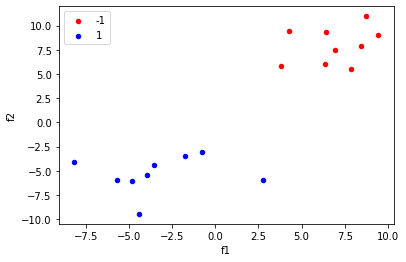

'\nfeatures_dict["label"] = labels\ndf = DataFrame(features_dict, labels)\ncolors = {-1:\'red\', 1:\'blue\'}\nfig, ax = plt.subplots()\ngrouped = df.groupby(\'label\')\n\nfor key, group in grouped:\n    group.plot(ax=ax, kind=\'scatter\', x=\'f2\', y=\'f3\', label=key, color=colors[key])\nplt.show()\n\nfeatures_dict["label"] = labels\ndf = DataFrame(features_dict, labels)\ncolors = {-1:\'red\', 1:\'blue\'}\nfig, ax = plt.subplots()\ngrouped = df.groupby(\'label\')\n\nfor key, group in grouped:\n    group.plot(ax=ax, kind=\'scatter\', x=\'f3\', y=\'f4\', label=key, color=colors[key])\nplt.show()\n'

In [8]:
# Creating a dataset
# The smaller the cluster_std, the more appart and easier to distinguish they are
num_samples_train = 15
num_samples_test = 3
num_features = 2

num_samples = num_samples_train + num_samples_test
all_features, all_labels_init = make_blobs(n_samples=num_samples, centers=2, cluster_std=2, n_features=num_features)

features_train = all_features[:num_samples_train]
features_test = all_features[num_samples_train:]

labels = all_labels_init
labels = np.where(all_labels_init == 0, -1, all_labels_init)

labels_train = labels[:num_samples_train]
labels_test = labels[num_samples_train:]

# Displaying the dataset
features_dict = {}
for i in range(len(all_features[0])):
    col_name = "f" + str(i+1)
    features_dict [col_name] = all_features[:,i]
    
features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f1', y='f2', label=key, color=colors[key])
plt.show()


"""
features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f2', y='f3', label=key, color=colors[key])
plt.show()

features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f3', y='f4', label=key, color=colors[key])
plt.show()
"""

In [9]:
### Custom Feature Map

# for now, we have as many qubits as features
num_qubits = num_features

# iter is number of times to repeat the circuit
iter = 1              

# creating a list of parameters
x = ParameterVector('x', length=num_qubits)  
custom_circ = QuantumCircuit(num_qubits)

# defining the parametrised circuit to be used as a feature map
for _ in range(iter):
    for i in range(num_qubits):
        custom_circ.h(i)
    for i in range(num_qubits):
        custom_circ.rz(x[i], i)
    for i in range(1, num_qubits):
        custom_circ.cx(0, i)
        custom_circ.rz(x[i], i)
        custom_circ.cx(0, i)
custom_circ.draw()

# creating the feature map and extracting the kernel matrix
backend = QuantumInstance(BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed)
fm = PauliFeatureMap(num_qubits, reps=1)
print(fm)
#qk = QuantumKernel(feature_map=custom_circ, quantum_instance=backend)
qk = QuantumKernel(feature_map=fm, quantum_instance=backend)
K = qk.evaluate(features_train)

     ┌─────────────────────────────┐
q_0: ┤0                            ├
     │  PauliFeatureMap(x[0],x[1]) │
q_1: ┤1                            ├
     └─────────────────────────────┘


In [4]:
# Computing the alphas of the SVM algorithm
for lambda_svm in [0.001, 0.01, 0.1, 1, 10, 1000]:
    Q = np.zeros((num_samples_train, num_samples_train))
    for i in range(num_samples_train):
        for j in range(num_samples_train):
            Q[i][j] = labels[i] * labels[j] * K[i][j]
    Pm = np.eye(num_samples_train) / lambda_svm + Q

    P = matrix(Pm, tc='d')
    q = matrix(-np.ones(num_samples_train), tc='d')
    G = matrix(-np.eye(num_samples_train), tc='d')
    h = matrix(np.zeros(num_samples_train), tc='d')

    sol = solvers.qp(P,q,G,h)
    alpha = (np.array(sol['x']).T)[0]
    print(alpha[0:4])
    good = 0
    bad = 0
    for test_idx in range(num_samples_test):
        new_sum = 0

        for train_idx in range(num_samples_train):
            pair = np.zeros((2, num_features))
            pair[0] = features_train[train_idx]
            pair[1] = features_test[test_idx]
            current_K = qk.evaluate(pair)
            new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)

        if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
            good = good + 1
            print("Good for " + str(test_idx))
        else:
            bad = bad + 1
            print("Bad for " + str(test_idx))

    print("Lambda is: ", lambda_svm)
    print("Well classifed: ", good)
    print("Bad classified: ", bad)
    print("Accuracy: ", round(good / (good + bad), 4) * 100)
    print('\n################################\n')

     pcost       dcost       gap    pres   dres
 0: -7.4924e-02 -2.2462e-01  1e-01  0e+00  1e+00
 1: -7.4924e-02 -7.6422e-02  1e-03  3e-18  1e-02
 2: -7.4924e-02 -7.4939e-02  1e-05  2e-18  1e-04
 3: -7.4924e-02 -7.4924e-02  1e-07  3e-18  1e-06
 4: -7.4924e-02 -7.4924e-02  1e-09  3e-18  1e-08
Optimal solution found.
[0.00100029 0.00100007 0.00099886 0.00099798]
Bad for 0
Good for 1
Good for 2
Bad for 3
Good for 4
Bad for 5
Bad for 6
Good for 7
Bad for 8
Good for 9
Good for 10
Bad for 11
Bad for 12
Bad for 13
Bad for 14
Lambda is:  0.001
Well classified:  6
Bad classified:  9
Accuracy:  40.0

################################

     pcost       dcost       gap    pres   dres
 0: -7.4241e-01 -2.2131e+00  1e+00  0e+00  1e+00
 1: -7.4247e-01 -7.5736e-01  1e-02  2e-17  1e-02
 2: -7.4248e-01 -7.4263e-01  1e-04  2e-17  1e-04
 3: -7.4248e-01 -7.4248e-01  1e-06  3e-17  1e-06
 4: -7.4248e-01 -7.4248e-01  1e-08  2e-17  1e-08
Optimal solution found.
[0.01002802 0.0100059  0.00988753 0.00979999]
Bad f

In [10]:
# Computing the alphas of the SVM algorithm
lambda_svm = 100
Q = np.zeros((num_samples_train, num_samples_train))
for i in range(num_samples_train):
    for j in range(num_samples_train):
        Q[i][j] = labels[i] * labels[j] * K[i][j]
Pm = np.eye(num_samples_train) / lambda_svm + Q

P = matrix(Pm, tc='d')
q = matrix(-np.ones(num_samples_train), tc='d')
G = matrix(-np.eye(num_samples_train), tc='d')
h = matrix(np.zeros(num_samples_train), tc='d')

sol = solvers.qp(P,q,G,h)
alpha = (np.array(sol['x']).T)[0]
print(alpha[0:4])
good = 0
bad = 0

w_0 = 0
w_1 = 0

for test_idx in range(num_samples_test):
    new_sum = 0

    for train_idx in range(num_samples_train):
        pair = np.zeros((2, num_features))
        pair[0] = features_train[train_idx]
        pair[1] = features_test[test_idx]
        current_K = qk.evaluate(pair)
        new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
        w_0 = w_0 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][0]
        w_1 = w_1 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][1]

    if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
        good = good + 1
        print("Good for " + str(test_idx))
    else:
        bad = bad + 1
        print("Bad for " + str(test_idx))

print("Lambda is: ", lambda_svm)
print("Well classified: ", good)
print("Bad classified: ", bad)
print("Accuracy: ", round(good / (good + bad), 4) * 100)
print('\n################################\n')

     pcost       dcost       gap    pres   dres
 0: -8.9753e+00 -2.1650e+01  1e+01  0e+00  2e+00
 1: -1.4307e+01 -1.7090e+01  3e+00  6e-16  7e-01
 2: -2.2885e+01 -2.8374e+01  5e+00  1e-15  4e-01
 3: -2.4952e+01 -2.5561e+01  6e-01  4e-15  2e-02
 4: -2.4987e+01 -2.5011e+01  2e-02  2e-15  8e-04
 5: -2.4990e+01 -2.4991e+01  9e-04  4e-15  1e-05
 6: -2.4990e+01 -2.4990e+01  8e-05  4e-15  7e-08
 7: -2.4990e+01 -2.4990e+01  5e-06  3e-15  1e-15
Optimal solution found.
[2.14552508e-08 2.35248521e+00 6.14078010e-04 1.01902938e-07]
Good for 0
Good for 1
Bad for 2
Lambda is:  100
Well classified:  2
Bad classified:  1
Accuracy:  66.67

################################



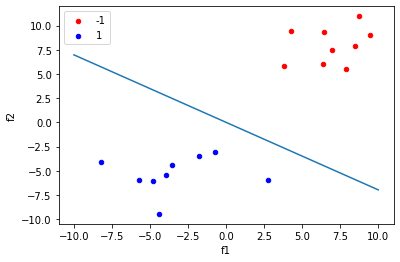

In [12]:
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f1', y='f2', label=key, color=colors[key])

x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_0 * x0_sample / w_1
ax.plot(x0_sample, x1_sample)

plt.show()